In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('../..'))
import torch
import numpy as np
import utils
import matplotlib.pyplot as plt
from dataset import DataSet
import pandas as pd
%load_ext autoreload
np.random.seed(2) 
torch.manual_seed(2)

In [2]:
%autoreload


In [3]:
lcs = utils.get_data('../../datasets/ZTF_g', split=0.02)


validated 3408 files out of 3408 for band='g'
created union_tp attribute of length 3500
dataset created w/ shape (2559, 1, 1974, 3)
train size: 51, valid size: 50, test size: 2508


In [4]:
net, optimizer, args, epoch, loss, train_loss, test_loss = utils.load_checkpoint('../checkpoints/final/ZTF_g0.668415367603302.h5', lcs.data_obj)


=> loading checkpoint '../checkpoints/final/ZTF_g0.668415367603302.h5'
Namespace(n_union_tp=3500, data_folder='datasets/ZTF_g', checkpoint='datasets/ZTF_g0.7037358283996582.h5', start_col=1, inc_errors=False, print_at=1, embed_time=128, enc_num_heads=16, latent_dim=64, mixing='concat', num_ref_points=16, rec_hidden=128, width=512, save_at=30, patience=100, early_stopping=False, niters=20000, frac=0.5, batch_size=2, mse_weight=5.0, dropout=0.0, num_resamples=0, lr=1e-06, scheduler=False, warmup=4000, kl_zero=False, kl_annealing=True, net='hetvae', device='mps', const_var=False, var_per_dim=False, std=0.1, seed=2, save=True, k_iwae=1)


In [9]:
recon_info = utils.predict(lcs.data_obj['train_loader'], net,target_x=None,frac=0.5,qz_mean=False,k_iwae=5)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [02:25<00:00,  5.61s/it]


In [10]:
recons = recon_info['recons']
examples = recon_info['examples']

# input light curves
tp = examples['tp']

# unsubsampled y
y = examples['target']

## subsampled y (if it is at all)
inputs = examples['inputs']
sub_mask = examples['mask']

## preds 
pred_mean = recons['pred_mean']
pred_std = recons['pred_std']
pred_tp = recons['target_tp']


In [11]:
sub_mask = np.ma.make_mask(sub_mask) # make 0/1 mask boolean
recon_mask = np.logical_xor(sub_mask,y)

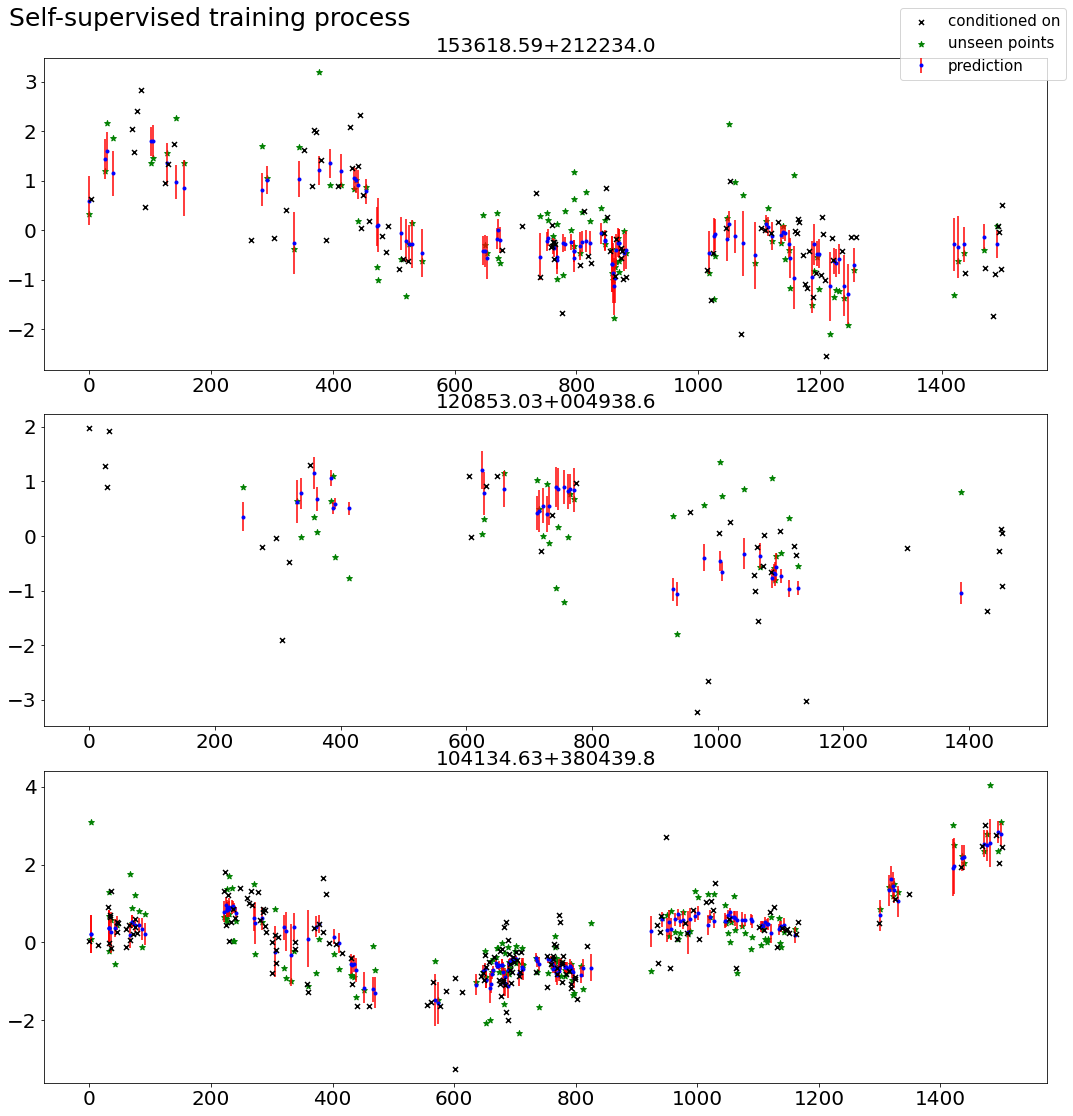

In [12]:
figsize=(15,15)
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
n=5
dims = pred_mean.shape[2]
fig,ax = plt.subplots(3,dims,figsize=figsize, squeeze=False)
fig.tight_layout()

for ex in range(3):
    ax[ex,0].set_title(lcs.valid_files_df.index[ex],fontsize=20)
    
    input_i = inputs[ex].nonzero()[0]  
    
    for band in range(dims):
        
        ### inputs 
        ax[ex,band].scatter(tp[ex,input_i], inputs[ex,input_i,band], c='black', marker='x', zorder=30, label='conditioned on', s=25)
        
        ## unseen target points
        rm = recon_mask[ex,:,band]
        ax[ex,band].scatter(tp[ex,rm],y[ex,rm,band],marker='*',color='green',label='unseen points')
        
        ## predictions at those points
        ax[ex,band].errorbar(pred_tp[ex,rm], pred_mean[ex,rm,band], yerr=pred_std[ex,rm,band],fmt='.', c='blue', ecolor='red', label='prediction')
        # errorbar at preds w/ recon mask 
        
        
handles, labels = fig.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(by_label.values(), by_label.keys(),fontsize=15)

fig.suptitle('Self-supervised training process',fontsize=25,x=0.2,y=1.03)
fig.savefig('../img/training_process',bbox_inches='tight')